# DCR analysis

## Processing of waveforms

**GOAL**
- count all events
- make plot amplitude VS time to discriminate between 1 phe signals ("real counts" and afterpulses) and 2 phe signals (crosstalks)
- evaluate % of afterpulses and crosstalks wrt total

Notes: time axis has a physical minimum due to width of waveform

**Procedure**
- csv files of waveforms and timestamps combined
- csv files, sliced into single waveforms
- find minima (absolute and relative), plot them, count them (count single points of absolute minimum) and save their timestamps and amplitude
- from amplitude value you understand if a peak is noise (crosstalk, afterpulse)
- get amplitudes and timestamps of each minimum

*Afterpulse*: happens tipically at 0.5 $\mu$s after a real signal, and has an amplitude almost equal to 1 phe; threshold for considering an event an afterpulse of the event before is 6 $\mu$s.  
*Crosstalk*: single peak of amplitude 2 phe

## Goals, tips and tricks

You have to find an automated way to find the "good" absolute minimum.
How?

- [x] Extrapolate baseline: evaluate it by using only pre-trigger amplitudes.
- [ ] **Raise an error or quarantine the snippet if you have a number of minima that is too big**
- [ ] **Evaluate the derivative of the ramp up of a peak**
- [ ] Dark count rate is number of total events / total time --> **calculate total time**
- [x] Discriminate if two peaks have a distance between each other that is too small (is less than the width of the window)

Options to follow to throw away noisy signals:

1. Throw away all noise: if the waveform is not good (has more than one minimum that goes over the threshold) throw it away completely; have to count all the waveforms that are thrown and estimate fraction of total events
2. Check on saturated events: must be true to have points over the threshold and also have some number of points (like, 10) in a very narrow range of values (all equal)

Final goals:

1. Create 2D plot with time deltas (x) and amplitude (y): time deltas are the differences between timestamps of any two successive "good" peaks

### Code from Guarise

Already commented by Guarise, I already reviewed it.

---

### My code structure

Starting from code from Guarise, polishing and dividing in different functions

**Header**
```python

def read_wf(file_name):
    """
    Basic read function with automatic timestamp or wf detection from file_name;
    also constructs both dataframes
    """
    if file name contains 'time.csv' then do...
    if else file_name contains wf.csv then do...
    else NameError
        raise

def analysis_wf(timestamp_table, wf_table, wf_datapoints, threshold, distance, inplace=True):
    """
    This function finds all the minima in the waveforms and selects the "good ones" based on
    - minim amplitude = threshold (mV)
    - number of data in between two consecutive absolute minima = distance (adim, integer)
    Option inplace tells if the function modifies the original wf dataframe by adding a column with good minima.
    if inplace == True: return nothing
    if inplace == False: return copy of original dataframe with new column of good minima
    """
    
def plot_wf(timestamp_table, wf_table, wf_datapoints, loop=True, show=False, save=False,): #wf_table must contain the "good minima" column
    """
    This function plots the waveform by its data, in a amplitude(mV) vs timestamp plot.
    Automatically detects if the dataframe contains one or more waveforms and if loop==True loops on all the wf,
    otherwise only plots the first one (good for debuggind/building phases)
    Options:
    - show scatter only (wf) [doesn't require "good minima" column]
    - show minima
    This function returns nothing.
    """

def plot_dcr(minimum_table, hist=True):
    """
    Only needs a dataframe minimum_table with the list of the minima and the related timestamps.
    Plots an amplitude (mV) vs delta_t (ns) graph, useful to detect noise source.
    Option hist=True plots an histogram subplot under the 2D plot, representing the integral in the vertical
    direction of the ampli vs dt plot.
    """
```
        

In [45]:
import os
import re
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import argrelextrema

In [44]:
# from dcr_functions import *

## Read

In [46]:
def read_wf(fname):
    """
    Basic read function with automatic timestamp or wf file type detection.
    
    Parameters
    ----------
    - fname: relative path of the file with respect to the current working directory
    
    Returns
    -------
    Pandas' dataframe of the data provided.
    
    ############################ UPDATES TO MAKE ####################################
    - requires both files, one after the other and detects which one is still missing 
        after the first is provided
    - checks if they refer to the same data taking (from the path itself)
    
    #################################################################################

    """
    
    # If the file provided is a timestamp file, follow this routine:
    # - open the file
    # - make a dataframe with the timestamps; the header is as default in line 0
    # - timestamps are relative and provide the time interval with respect to the previous trigger:
    #    make them absolute by computing the cumulative of each timestamp with cumsum method of pd
    if re.search("time.csv", fname): 
        timestamp_file_name = fname
        timestamp_path = os.path.join(os.getcwd(),timestamp_file_name)
        timestamp_table = pd.read_csv(timestamp_path) 
            # if file is not found, FileNotFoundError is raised automatically
        timestamp_table.rename(columns = {'X: (s)': 'Event', 'Y: (Hits)':'Timestamp'}, inplace = True)
        N_of_events = len(timestamp_table) # = 1000
        timestamp_table["Timestamp"] = timestamp_table["Timestamp"].cumsum(axis=0)
        
        return timestamp_table
        
    # If the file provided is a waveform file, follow this routine:
    # - open the file
    # - detect the number of datapoints in each waveform, wf_datapoints = 6250
    # - detect end of header ("TIME") and make a dataframe with the wf data
    elif re.search("wf.csv", fname):
        wf_file_name = fname
        wf_path = os.path.join(os.getcwd(),wf_file_name)
        wf_table = pd.DataFrame()
        
        with open(wf_file_name, 'r') as file_wf:
                # if file is not found, FileNotFoundError is raised automatically
            lines = file_wf.readlines()
            for line_counter, line in enumerate(lines):
                if line.startswith("Record Length"): wf_datapoints = int(line.split(',')[-1]) # = 6250
                if line.startswith("Horizontal"): time_unit = str(line.split(',')[-1]).rstrip("\n") # = s\n
                if line.startswith("Vertical"): ampl_unit = str(line.split(',')[-1]).rstrip("\n") # = V\n
                if line.startswith("FastFrame"): wf_events = int(line.split(',')[-1]) # = 1000
                    # To implement when both files are required by the function
                    # if wf_events != N_of_events: break
                if line.startswith("TIME"):
                    wf_table = pd.read_csv(wf_path, header = line_counter-1)
                    break
        
        meta = pd.DataFrame.from_dict({
            'path' : wf_path,
            'n events' : wf_events,
            'data points' : wf_datapoints,
            'time units' : time_unit,
            'ampl units' : ampl_unit,
        }, orient='index')
                    
        return wf_table, meta
    
    else:
        raise NameError("Please provide the path to a waveform or timestamp comma-separated file (.csv).")

## Analysis

In [172]:
def analysis(timestamp_table, wf_table, custom_n_events=1000, inplace=False, time_adjust=True,
             threshold=0.006, distance=50, many_minima=6250,
             plot=False, save_plot=False):
    """Function to analyze waveform data and locate clean signal peaks.
    
    This function finds all the minima in each waveform and selects the "good ones" based on the values
    of threshold (V) and distance.
   
   ------
   Input:
   - timestamp_table: pandas.DataFrame
       Dataframe with timestamps
   - wf_table: pandas.DataFrame
       Dataframe with waveforms in list mode
   - custom_n_events: int, deafult 1000
       Number of events to analyze (starts from the first waveform in any case)
   - inplace: bool, default False
       If True, modifies the input dataframe wf_table. If False, returns a copy.
   - time_adjust: bool, default True
       If True, adds timestamps from timestamp_table to wf_table. May be kept
       True for the first time the analysis is run on the dataset, switch
       to False afterwards.
   - threshold: float, default 0.006 [V]
       Minimum value of signal to discriminate it from noise, in units of V
   - distance: int, default 50
       Number of data in between two consecutive absolute minima
   - many_minima: int, default 6250 (# data in single waveform)
       Provide a number of minimum minima to be found to turn on or off a warning 
       that is raised if in the waveform there are more than that number of minima.
       Also provides additional column in dataframe with code "bad_wf" for
       waveforms that satisfy the above condition.
   - plot: bool, default False
       If True, plot the scatterplot of the waveforms with the relative minima in a
       recursive way
   
   --------
   Returns:
   - copy of original dataframe with added columns of minima (total) and clean minima (based
       on threshold and distance)
    
    """
    
    ############################# UPDATES TO MAKE ####################################
    # - [x] RETURNS wf_table complete with all clean minima
    # - [x] MUST HAVE inplace=True/False option: like this you're rewriting wf_table every time
    # - [x] must decide if you want or not to be able to plot relative minima
    # - [ ] discard saturated waveforms: must have a lot of almost-same-amplitude points
    #     Note: they must be points above the threshold, at least
    # - [x] identify waveforms with too many minima
    #     - [x] count # of discarded waveforms and get fraction wrt total 
    # - [x] Add tag "bad" along with minimum list, to be added as column in final, total df
    ##################################################################################
    
    start_time = time.time()
    
    N_of_events = custom_n_events        
    wf_datapoints = wf_table.iloc[:,0].size/1000
    
    general_clean_min = []
    general_bad = []
    N_bad_wf = 0
    
    for n in range(N_of_events):
        print("Analysis of event number " + str(n), end='\r') #'\r' overwrites output
        event_name = 'Event_' + str(n) + '.png'
        
        if time_adjust == True:
            wf_table["TIME"].loc[wf_datapoints*n: (wf_datapoints*(n+1))-1] += timestamp_table.at[n,"Timestamp"]
        
        single_wf = wf_table.loc[wf_datapoints*n: (wf_datapoints*(n+1))-1].copy()
        
        minimum_list = argrelextrema(single_wf.CH1.values, np.less_equal, order = distance)[0]
        single_wf.loc[:,'min'] = single_wf.iloc[minimum_list]['CH1']
        baseline = np.polyfit(single_wf["TIME"].iloc[0:250], single_wf["CH1"].iloc[0:250],0)[0]

        gap = threshold
        distance = distance
        
        clean_minimum_list = []
        previous_index = minimum_list[0]
        for index in minimum_list:
            if (baseline - single_wf["CH1"].iat[index] > gap) and (index > previous_index + distance):
                clean_minimum_list.append(index)
                previous_index = index
                
        single_wf.loc[:,'clean_min'] = single_wf.iloc[clean_minimum_list]['CH1']

        wf_index = (n*wf_datapoints)
        for index in clean_minimum_list:
            general_clean_min.append(index + wf_index)
            
            if len(minimum_list) > many_minima:
                general_bad.append(index + wf_index)
                N_bad_wf += 1
            
        if plot==True:
            plt.plot(single_wf["TIME"], single_wf['CH1'], linestyle="-", linewidth=1)
            plt.scatter(single_wf["TIME"], single_wf['min'], color="darkred")
            plt.scatter(single_wf["TIME"], single_wf['clean_min'], color="green")
            plt.axhline(baseline, c='b')
            plt.show()
            
        if save_plot==True:
            figure_path = os.path.join(os.path.join(os.getcwd(),'grafici'), event_name)
            plt.savefig(figure_path)
            
            plt.close()
    
    print('\nAnalysis completed.')
    print('Fraction of waveforms with too many minima ("bad_wf") on total: %s%%' % format(N_bad_wf/custom_n_events*100,".2f"))
    
    if many_minima < 6250:
        bad_list = ['bad_wf' for item in general_bad]
        bad = pd.DataFrame(bad_list, index=general_bad, columns=['code'])
    
    if inplace==True:
        wf_table.loc[:,'clean_min'] = wf_table.iloc[general_clean_min]['CH1']
        wf_table = wf_table.join(bad)
        wf_table.code.fillna(value='good', inplace=True)
        print("Process completed in %s s." % (format(time.time()-start_time,".2f")))


    if inplace == False:
        copy = wf_table.copy()
        copy.loc[:,'clean_min'] = copy.iloc[general_clean_min]['CH1']
        copy = copy.join(bad)
        copy.code.fillna(value='good', inplace=True)
        print("Process completed in %s s." % (format(time.time()-start_time,".2f")))
        return copy

## Plot scatter

In [124]:
############################## PLOTTING ##############################################
def plot_wf(wf_table, N_of_events=1000, loop=False, show=True, save=False,): #wf_table must contain the "good minima" column
    """
    This function plots the waveform by its data, in a amplitude(V) vs timestamp(s) plot.
    Automatically detects if the dataframe contains one or more waveforms and if loop==True
    loops on all the wf, otherwise only plots the first one (good for debuggind/building phases)
    Options:
    - show scatter only (wf) [doesn't require "good minima" column]
    - show minima
    This function returns nothing, and shows the plot.

    ############################ UPDATES TO MAKE ####################################
    - see if this works :)
    #################################################################################
    """
    for n in range(N_of_events): # N_of_events = 1000
        print("Analizzando l'evento numero " + str(n), end='\r') #'\r' overwrites output
        event_name = 'Event_' + str(n) + '.png'
        wf_datapoints = wf_table.iloc[:,0].size/N_of_events
        
        single_wf = wf_table.loc[wf_datapoints*n: (wf_datapoints*(n+1))-1].copy()
        baseline = np.polyfit(single_wf["TIME"].iloc[0:250], single_wf["CH1"].iloc[0:250],0)[0]

        plt.plot(single_wf["TIME"], single_wf['CH1'], linestyle="-", linewidth=1)
        # plt.scatter(single_wf["TIME"], single_wf['min'], color="darkred")
        plt.scatter(single_wf["TIME"], single_wf['clean_min'], color="green")
        plt.axhline(baseline, c='b')
        
        if save==True:
            figure_path = os.path.join(os.path.join(os.getcwd(),'grafici'), event_name)
            plt.savefig(figure_path)

        if show==True:
            plt.show()
            
        plt.close()
    
        if loop!=True:
            break

## Plot 2D

In [21]:
# ora abbiamo una lista di minimi considerati validi, con rispettivi tempi e ampiezze (e altre colonne ridondanti che servivano per i plot)
min_list = analysis(timestamp_table, wf_table,wf_data_points)

# seleziono solo le righe corrispondenti ai minimi validi, utilizzando la lista di indici definita prima
minimum_table = wf_table.loc[min_list].copy()

# infine calcolo le differenze dei tempi relativi ai minimi delle waveforms
# diff calcola, per ogni riga, la differenza con la riga precedente
# (o due righe indietro se periods =2, o tre se periods=3, ecc)
minimum_table['TIME'] = minimum_table['TIME'].diff(periods=1)
minimum_table = minimum_table.iloc[1:,:]

# una volta trovati tutti picchi possiamo costruire il grafico ed estrarre i valori di DCR, AP e CT
minimum_table.rename(columns={'TIME':'Delta T (s)','CH1':'Amplitude (V)'}, inplace = True)
plt.scatter(minimum_table['Delta T (s)'],minimum_table['Amplitude (V)'])
plt.xscale("log")
plt.savefig('Amplitude_vs_dt.pdf')
plt.show()
plt.close()
# La Dark Count Rate è semplicemente il numero di eventi considerati validi, diviso per il tempo totale di misura
# la probabilità di After Pulse è la precentuale di eventi con delta t inferiore a 6 microsecondi
# la probabilità di Cross Talk è la percentuale di eventi con ampiezza superiore a 1 p.e. (p.e. = fotoelettrone, nel nostro caso pari a 8 mV)

# Blocks for testing

In [150]:
wf_table, meta = read_wf(".\\Data\\DCR\\HPKR00030_2cicli_OV3_wf.csv")

In [43]:
meta

,0
path,C:\Users\MARTINA\Desktop\OOPROJECT\pyproj\bran...
n events,1000
data points,6250
time units,s
ampl units,V


In [6]:
time_table = read_wf(".\\Data\\DCR\\HPKR00030_2cicli_OV3_time.csv")

In [149]:
wf_table.head()

,TIME,CH1
0,-9.994500e-08,-0.000809
1,-9.978500e-08,-0.000809
2,-9.962500e-08,-0.000809
3,-9.946500e-08,-0.000809
4,-9.930500e-08,-0.000809


In [8]:
time_table.head()

,Event,Timestamp
0,0,0.000000
1,1,0.015416
2,2,0.015771
3,3,0.020706
4,4,0.030981


In [157]:
wf_table.loc[wf_table.CH1.values==(-np.inf)]

,TIME,CH1
413329,18.002220,-inf
413330,18.002220,-inf
413331,18.002220,-inf
413332,18.002220,-inf
413333,18.002220,-inf
...,...,...
5319702,815.903334,-inf
5319703,815.903334,-inf
5319704,815.903334,-inf
5319705,815.903334,-inf


In [173]:
wf = analysis(time_table, wf_table, custom_n_events=1000, plot=False, inplace=False, many_minima=500, time_adjust=False)

Analysis of event number 999
Analysis completed.
Fraction of waveforms with too many minima ("bad_wf") on total: 2.40%
Process completed in 22.54 s.


In [181]:
wf.head()

,TIME,CH1,clean_min,code
0,-9.994500e-08,-0.000809,NaN,good
1,-9.978500e-08,-0.000809,NaN,good
2,-9.962500e-08,-0.000809,NaN,good
3,-9.946500e-08,-0.000809,NaN,good
4,-9.930500e-08,-0.000809,NaN,good


In [182]:
    ############################# UPDATES TO MAKE ####################################
    # - [ ] 
    # - [ ] 
    ##################################################################################

minimum_table = wf.dropna() # drops all rows with NaNs, that are found in clean_min only
minimum_table['TIME'] = minimum_table['TIME'].diff(periods=1)
minimum_table = minimum_table.iloc[1:,:]

In [185]:
minimum_table['Delta T (s)'].values.min()

-836.264929662507

C:\Users\MARTINA\AppData\Local\Temp/ipykernel_11936/3533848563.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minimum_table['TIME'] = minimum_table['TIME'].diff(periods=1)


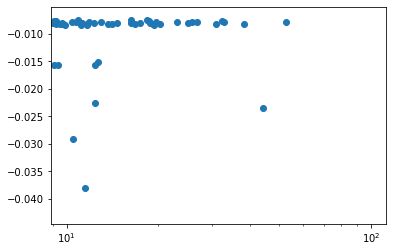

In [182]:
# una volta trovati tutti picchi possiamo costruire il grafico ed estrarre i valori di DCR, AP e CT
minimum_table.rename(columns={'TIME':'Delta T (s)','CH1':'Amplitude (V)'}, inplace = True)
plt.scatter(minimum_table['Delta T (s)'],minimum_table['Amplitude (V)'])
plt.xscale("log")
plt.savefig('Amplitude_vs_dt.pdf')
plt.show()
plt.close()
# La Dark Count Rate è semplicemente il numero di eventi considerati validi, diviso per il tempo totale di misura
# la probabilità di After Pulse è la precentuale di eventi con delta t inferiore a 6 microsecondi
# la probabilità di Cross Talk è la percentuale di eventi con ampiezza superiore a 1 p.e. (p.e. = fotoelettrone, nel nostro caso pari a 8 mV)

In [170]:
wf.loc[wf.CH1==(-np.inf)]

,TIME,CH1,clean_min,code
413329,90.011100,-inf,NaN,NaN
413330,90.011100,-inf,NaN,NaN
413331,90.011100,-inf,NaN,NaN
413332,90.011100,-inf,NaN,NaN
413333,90.011100,-inf,NaN,NaN
...,...,...,...,...
5319702,815.903334,-inf,NaN,NaN
5319703,815.903334,-inf,NaN,NaN
5319704,815.903334,-inf,NaN,NaN
5319705,815.903334,-inf,NaN,NaN
